In [1]:
## Mathmatics libraries
import numpy as np
import math

## Image Processing libraries
import skimage
from skimage import exposure

import scipy.misc as misc
import cv2 as cv
import rawpy
import imageio

## Visual and plotting libraries
import matplotlib.pyplot as plt

### import image

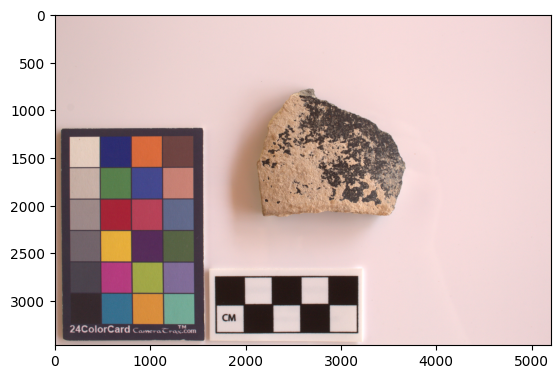

In [2]:
img = rawpy.imread('../test_images/3.CR2')
assert img is not None, "file could not be read, check with os.path.exists()"
img = img.postprocess()
plt.imshow(img)

### Thresholding

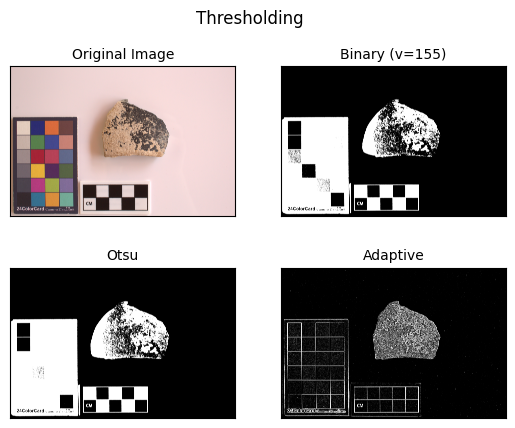

In [3]:
blur = cv.GaussianBlur(img,(5,5),0)
img_g = cv.cvtColor(blur, cv.COLOR_BGR2GRAY)
kernel_size = 6 if max(img.shape) >= 1000 else 5
kernel = cv.getStructuringElement(cv.MORPH_RECT, (kernel_size, kernel_size))

ret1,thresh1 = cv.threshold(img_g,140,255,cv.THRESH_BINARY_INV)
ret2,thresh2 = cv.threshold(img_g,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
thresh3 = cv.adaptiveThreshold(img_g,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 31, 3)

images = [img, thresh1, thresh2, thresh3]
# plot images before coutour filling
titles = ['Original Image','Binary (v=155)', 'Otsu', 'Adaptive']
for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray',vmin=0,vmax=255)
    plt.title(titles[i], fontsize=10)
    plt.xticks([]),plt.yticks([])
    plt.suptitle('Thresholding')
plt.show()

In [4]:
def validCnt(cnt):
    (width, height)= cv.minAreaRect(cnt)[1]
    if width > 100 and height > 100 and cv.contourArea(cnt) > 500:
        return True

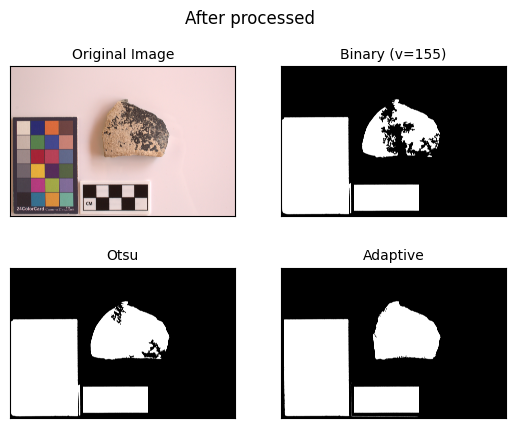

In [5]:
threshes = [thresh1, thresh2, thresh3]
images_processed = [img]
# contour filling
for thresh in threshes:
    thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
    filled = np.zeros_like(thresh)
    cnts, _ = cv.findContours(
    thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    for cnt in cnts:
        if validCnt(cnt):
            cv.drawContours(filled, [cnt], 0, 255, -1)
    filled = cv.morphologyEx(filled, cv.MORPH_OPEN, kernel)
    images_processed.append(filled)
        

titles = ['Original Image','Binary (v=155)', 'Otsu', 'Adaptive']
for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images_processed[i],'gray',vmin=0,vmax=255)
    # set size of title
    plt.title(titles[i], fontsize=10)
    plt.xticks([]),plt.yticks([])
    plt.suptitle('After processed')
plt.show()

In [6]:
# define range of colors in HSV
lower_blue = np.array([120, 50, 20])
upper_blue = np.array([158, 255, 255])
lower_green = np.array([40, 52, 70])
upper_green = np.array([82, 255, 255])  # TOFIX
lower_yellow = np.array([20, 100, 100])
upper_yellow = np.array([30, 255, 255])

lower_red = np.array([0, 100, 100])
upper_red = np.array([10, 255, 255])
lower_red2 = np.array([170, 100, 100])
upper_red2 = np.array([179, 255, 255])

lower_black = np.array([0, 0, 0])
upper_black = np.array([179, 255, 75])
lower_white = np.array([0, 0, 180])  # TOFIX
upper_white = np.array([0, 0, 255])  # TOFIX
# Create an array specify lower and upper range of colours
COLOR_RANGE = {'blue': [lower_blue, upper_blue],
                'green': [lower_green, upper_green],
                'yellow': [lower_yellow, upper_yellow],
                'red': [[lower_red, upper_red], [lower_red2, upper_red2]],
                'black': [lower_black, upper_black]}

In [7]:
# Detect the black region to guess the positions of 24checker and scaling card in an image 
def getCardsBlackPos(img, is24Checker = True):
    patchPos = {}
    
    img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)  # Convert BGR to HSV
    black_mask = cv.inRange(
        img_hsv, COLOR_RANGE['black'][0], COLOR_RANGE['black'][1])
    
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (10, 10))
    mask = cv.morphologyEx(black_mask.copy(), cv.MORPH_CLOSE, kernel)

    cnts, _ = cv.findContours(
        mask.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Fill the black color to get the card
    if is24Checker is True: 
        for cnt in cnts:
            cv.drawContours(mask, [cnt], 0, 255, -1)
    
    # Get rectangle only
    cnts = list(filter(lambda x: len(cv.approxPolyDP(
            x, 0.05*cv.arcLength(x, True), True)) == 4, cnts))

    cnts = sorted(cnts, reverse=True, key=cv.contourArea)

    if len(cnts) < 2: 
        raise Exception("No black squares detected.")
    if is24Checker is True: 
        _, _, w, h = cv.boundingRect(cnts[1])
        if w/h > 2 or h/w > 2: # Determine if is scale card
            patchPos['black'] = cv.boundingRect(cnts[1]) 
            patchPos['black2'] = cv.boundingRect(cnts[0])
        else: 
            patchPos['black'] = cv.boundingRect(cnts[0]) # Second largest is the scale card 
            patchPos['black2'] = cv.boundingRect(cnts[1])
    else: 
        patchPos['black'] = cv.boundingRect(cnts[1]) # The largest may be the blue patch
        
    # imUtils.drawPatchPos(img.copy(), patchPos)
    return patchPos

# Guess if a contour is a sherd
def isSherd(cnt, patchPos):
    x, y, w, h = cv.boundingRect(cnt)
    for pos in patchPos.values():
        # Axis-Aligned Bounding Box
        # Test if two bound box not intersect
        # Return True is sherd
        if not ((x + w) < pos[0] or x > (pos[0] + pos[2]) or y > (pos[1] + pos[3]) or (y + h) < pos[1]):
            return False
    return True

def getSherdCnt(img, cnts, is24Checker):
    patchPos = getCardsBlackPos(img.copy(), is24Checker)
    cnts = list(filter(lambda cnt: isSherd(cnt, patchPos), cnts))
    # print("Number of Contours found = " + str(len(cnts)))
    # print(cnts)
    # checking if max() arg is empty also filter out the unqualified images (e.g. ones with no colorChecker)
    return max(cnts, key=cv.contourArea)

# detect if 24-patch color card exists
def detect24Checker(img, detector, kernel_size=5):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    closing = cv.morphologyEx(img, cv.MORPH_CLOSE, kernel)
    processParams = cv.mcc.DetectorParameters_create()
    processParams.maxError = 0.05
    if not detector.process(closing, cv.mcc.MCC24, 1, params=processParams):
        return False
    return True

In [8]:
def getSherdCntByCircularity(cnts):
    candidates = []
    for cnt in cnts:
        if validCnt(cnt):
            area = cv.contourArea(cnt)
            perimeter = cv.arcLength(cnt, True)
            circularity = 4*math.pi*(area/perimeter**2)
            _,_,w,h = cv.boundingRect(cnt)
            rect_area = w*h
            extent = float(area)/rect_area
            if extent < 0.8:
                candidates.append(cnt)

    return candidates

In [9]:
if detect24Checker(img.copy(), cv.mcc.CCheckerDetector_create()):
    thresholded = images_processed[3]
else:
    thresholded = images_processed[2]

In [10]:
cnts, _ = cv.findContours(
    thresholded, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)


cnt_candidates:  1


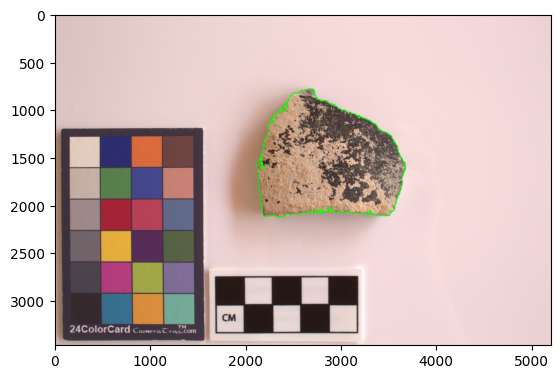

In [11]:
cnt_candidates = getSherdCntByCircularity(cnts)
print("cnt_candidates: ", len(cnt_candidates))
img_cnt = img.copy()
# select the contour with maximum circularity as the sherd contour
sherd_cnt = max(cnt_candidates, key=lambda cnt:4*math.pi*(cv.contourArea(cnt)/cv.arcLength(cnt, True)**2))

cv.drawContours(img_cnt, sherd_cnt, -1, (0, 255, 0), 10)
plt.imshow(img_cnt)

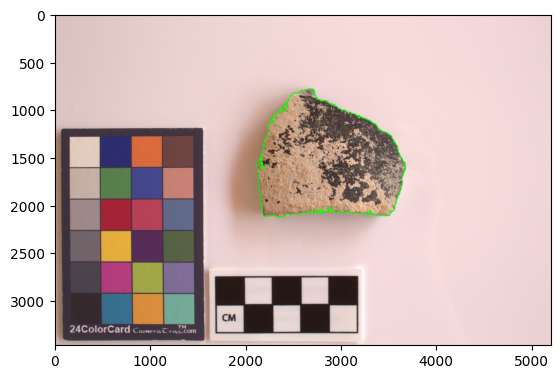

In [12]:
sherd_cnt = getSherdCnt(img.copy(), cnts, detect24Checker(img.copy(), cv.mcc.CCheckerDetector_create()))
img_cnt = img.copy()
cv.drawContours(img_cnt, sherd_cnt, -1, (0, 255, 0), 10)
plt.imshow(img_cnt)

/var/folders/n_/jj1s8yyj1kq0tqsd2cvk6f100000gn/T/ipykernel_78734/117989118.py:5: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


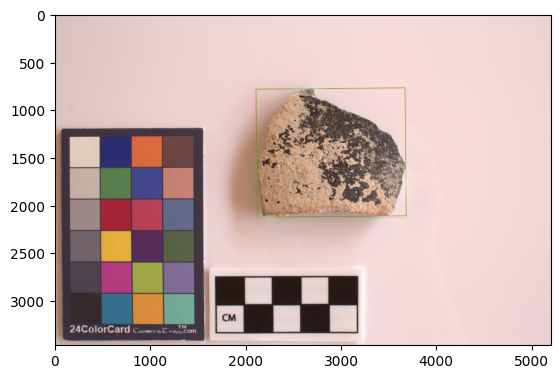

In [13]:
rect = cv.minAreaRect(sherd_cnt)
x, y, w, h = cv.boundingRect(sherd_cnt)

box = cv.boxPoints(rect)
box = np.int0(box)
img_cnt = img.copy()

cv.drawContours(img_cnt, [box], 0, (255, 0, 0), 2)
cv.rectangle(img_cnt, (x, y), (x + w, y + h), (0, 255, 0), 2)
plt.imshow(img_cnt)

{'m00': 1535059.5, 'm10': 4376607011.0, 'm01': 2376616674.6666665, 'm20': 12722073146890.75, 'm11': 6794948624752.541, 'm02': 3839604747147.083, 'm30': 3.76755124837555e+16, 'm21': 1.9820740101554676e+16, 'm12': 1.099677660929798e+16, 'm03': 6430111182812200.0, 'mu20': 243932118002.7129, 'mu11': 18978572252.530273, 'mu02': 160068665123.13232, 'mu30': 12669730849576.0, 'mu21': 15895610518351.5, 'mu12': -9083840011160.812, 'mu03': -10103273660393.0, 'nu20': 0.10351864036914472, 'nu11': 0.008054027537725314, 'nu02': 0.06792910550248372, 'nu30': 0.004339646506686102, 'nu21': 0.005444577432354488, 'nu12': -0.0031114042626287277, 'nu03': -0.0034605815046091113}


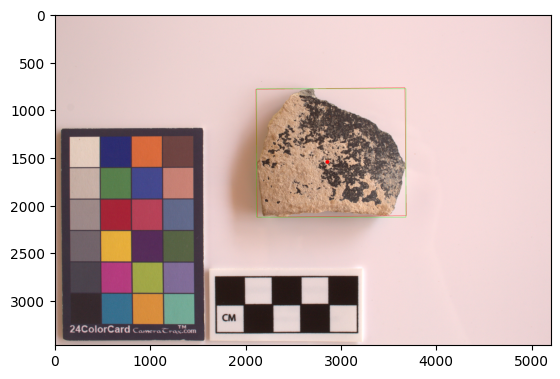

In [14]:
# find the center of mass of the sherd contour
M = cv.moments(sherd_cnt)
print(M)
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])
moment = [cX, cY]

cv.circle(img_cnt, moment, 20, (255,0,0), -1)
cv.putText(img_cnt, "centroid", (cX - 25, cY - 25),
            cv.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 2)

plt.imshow(img_cnt)

89.35865020751953
[740, 766]
[769, 820]


/var/folders/n_/jj1s8yyj1kq0tqsd2cvk6f100000gn/T/ipykernel_78734/2303828625.py:13: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  pts = np.int0(cv.transform(np.array([box]), M))[0]
/var/folders/n_/jj1s8yyj1kq0tqsd2cvk6f100000gn/T/ipykernel_78734/2303828625.py:14: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  moment_transformed = np.int0(cv.transform(np.array([moment]), M))[0]


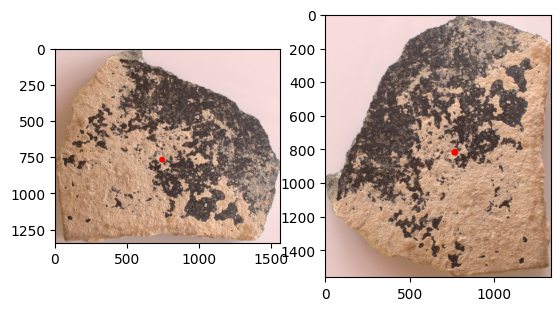

In [15]:
def crop_minAreaRect(img, rect, moment):

    # rotate img
    angle = rect[2]
    print(angle)
    rows,cols = img.shape[0], img.shape[1]
    M = cv.getRotationMatrix2D((rect[0][0],rect[0][1]),angle,1)
    img_rot = cv.warpAffine(img,M,(cols,rows))
    
    # rotate bounding box
    box = cv.boxPoints(rect)
    moment = [moment]
    pts = np.int0(cv.transform(np.array([box]), M))[0] 
    moment_transformed = np.int0(cv.transform(np.array([moment]), M))[0] 
    pts[pts < 0] = 0
    # crop
    img_crop = img_rot[pts[1][1]:pts[0][1], 
                       pts[1][0]:pts[2][0]]
    
    moment_transformed = [moment_transformed[0][0] - pts[1][0], moment_transformed[0][1] - pts[1][1]]
    return img_crop, moment_transformed

crop_after_rotation, moment_transformed = crop_minAreaRect(img, rect, moment)
crop_before_rotation = img[y:y+h, x:x+w]
moment_original = [moment[0] - x, moment[1] - y]
print(moment_original)
print(moment_transformed)
plt.figure()
plt.subplot(1,2,1)
cv.circle(crop_before_rotation, moment_original, 20, (255,0,0), -1)
plt.imshow(crop_before_rotation)
plt.subplot(1,2,2)
cv.circle(crop_after_rotation, moment_transformed, 20, (255,0,0), -1)
plt.imshow(crop_after_rotation)
plt.show()

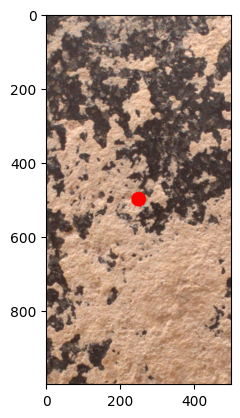

In [16]:
def crop_from_moment(img, moment, w, h):
    x, y = moment
    if img.shape[0] < img.shape[1]:
        cropped = img[(y - h//2) : (y + h//2), (x - w//2) : (x + w//2)]
    else:
        cropped = img[(y - w//2) : (y + w//2), (x - h//2) : (x + h//2)]
    return cropped

plt.imshow(crop_from_moment(crop_after_rotation, moment_transformed, 1000, 500))